## 1. Loading data

In [2]:
import numpy as np
import pandas as pd

def get_ds_infos():
    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    return dss

def set_data_types(data_types=["userAcceleration"]):
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t + ".x", t + ".y", t + ".z"])
        else:
            dt_list.append([t + ".roll", t + ".pitch", t + ".yaw"])
    return dt_list

def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list) * 3
    dataset = np.zeros((0, num_data_cols + 7)) if labeled else np.zeros((0, num_data_cols))
    
    ds_list = get_ds_infos()
    print("[INFO] -- Creating Time-Series")
    
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/' + act + '_' + str(trial) + '/sub_' + str(int(sub_id)) + '.csv'
                raw_data = pd.read_csv(fname).drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))

                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:, x_id] = (raw_data[axes] ** 2).sum(axis=1) ** 0.5
                    else:
                        vals[:, x_id * 3:(x_id + 1) * 3] = raw_data[axes].values
                vals = vals[:, :num_data_cols]

                if labeled:
                    lbls = np.array([[act_id, sub_id - 1,
                                      ds_list["weight"][sub_id - 1],
                                      ds_list["height"][sub_id - 1],
                                      ds_list["age"][sub_id - 1],
                                      ds_list["gender"][sub_id - 1],
                                      trial]] * len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset, vals, axis=0)

    cols = [str(axes[0][:-2]) for axes in dt_list] if mode == "mag" else [col for axes in dt_list for col in axes]
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]

    return pd.DataFrame(data=dataset, columns=cols)

# Configuration
ACT_LABELS = ["dws", "ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    "dws": [1, 2, 11], "ups": [3, 4, 12], "wlk": [7, 8, 15],
    "jog": [9, 16], "std": [6, 14], "sit": [5, 13]
}
sdt = ["attitude", "userAcceleration"]
act_labels = ACT_LABELS
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)

# Load dataset
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Dataset shape:", dataset.shape)


[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Dataset shape: (1412865, 13)


### Visualizing Raw Data

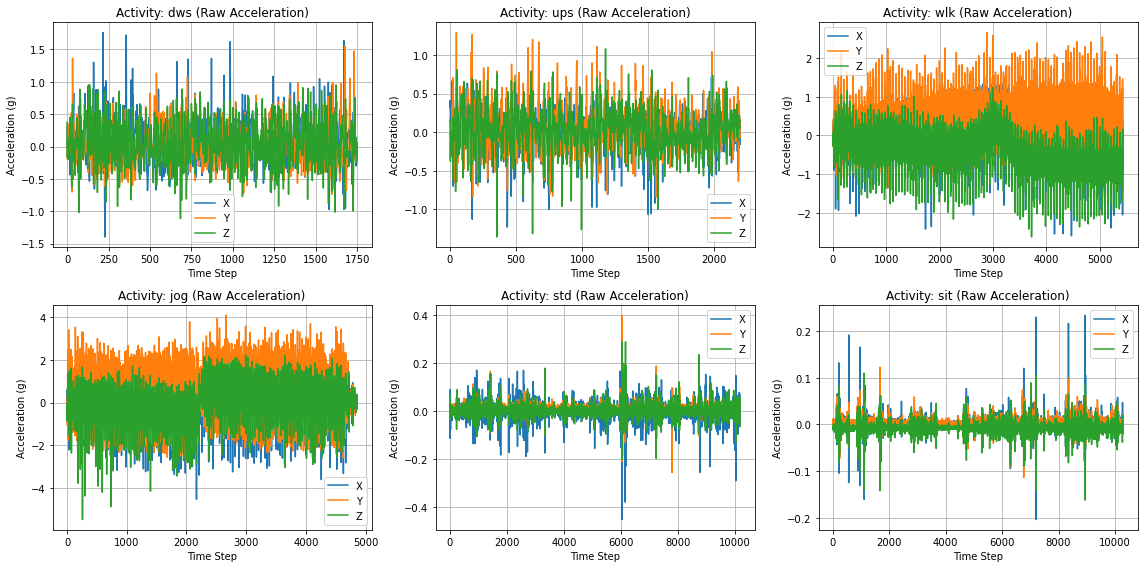

In [3]:
import matplotlib.pyplot as plt
import os

subject_id = 1  # You can change to visualize different subjects

# Plot one sample trial per activity
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, act in enumerate(ACT_LABELS):
    trial = TRIAL_CODES[act][0]  # Use first trial code for simplicity
    file_path = f"A_DeviceMotion_data/{act}_{trial}/sub_{subject_id}.csv"
    
    if not os.path.exists(file_path):
        print(f"[WARN] File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)
    accel_data = df[["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]]

    axes[i].plot(accel_data["userAcceleration.x"], label='X')
    axes[i].plot(accel_data["userAcceleration.y"], label='Y')
    axes[i].plot(accel_data["userAcceleration.z"], label='Z')
    axes[i].set_title(f"Activity: {act} (Raw Acceleration)")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel("Acceleration (g)")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## 2. Preprocessing

### 2.1 Segmentation Windowing

In [4]:
def window_data(X, y, window_size=128, step_size=64):
    X_win, y_win = [], []
    for i in range(0, len(X) - window_size, step_size):
        x_segment = X[i:i + window_size]
        y_segment = y[i:i + window_size]
        if len(np.unique(y_segment)) == 1:  # pure segment
            X_win.append(x_segment)
            y_win.append(y_segment[0])
    return np.array(X_win), np.array(y_win)

feature_cols = dataset.columns.difference(["act", "id", "weight", "height", "age", "gender", "trial"])
X_raw = dataset[feature_cols].values
y_raw = dataset["act"].values

# Apply windowing
X_windows, y_windows = window_data(X_raw, y_raw, window_size=128, step_size=64)
print(f"[INFO] -- Windowed data shape: {X_windows.shape}, Labels shape: {y_windows.shape}")


[INFO] -- Windowed data shape: (21791, 128, 6), Labels shape: (21791,)


### 2.2 Normalizing and One Hot Encoding

In [5]:
from tensorflow.keras.utils import to_categorical

def normalize_windows(X):
    for f in range(X.shape[2]):
        mean = X[:, :, f].mean()
        std = X[:, :, f].std()
        X[:, :, f] = (X[:, :, f] - mean) / (std + 1e-6)
    return X

def encode_labels(y, num_classes=None):
    return to_categorical(y, num_classes=num_classes)

X = normalize_windows(X_windows)
y = encode_labels(y_windows)
print(f"[INFO] -- Normalized X shape: {X.shape}, One-hot Y shape: {y.shape}")


[INFO] -- Normalized X shape: (21791, 128, 6), One-hot Y shape: (21791, 6)


### 2.3 Visualization

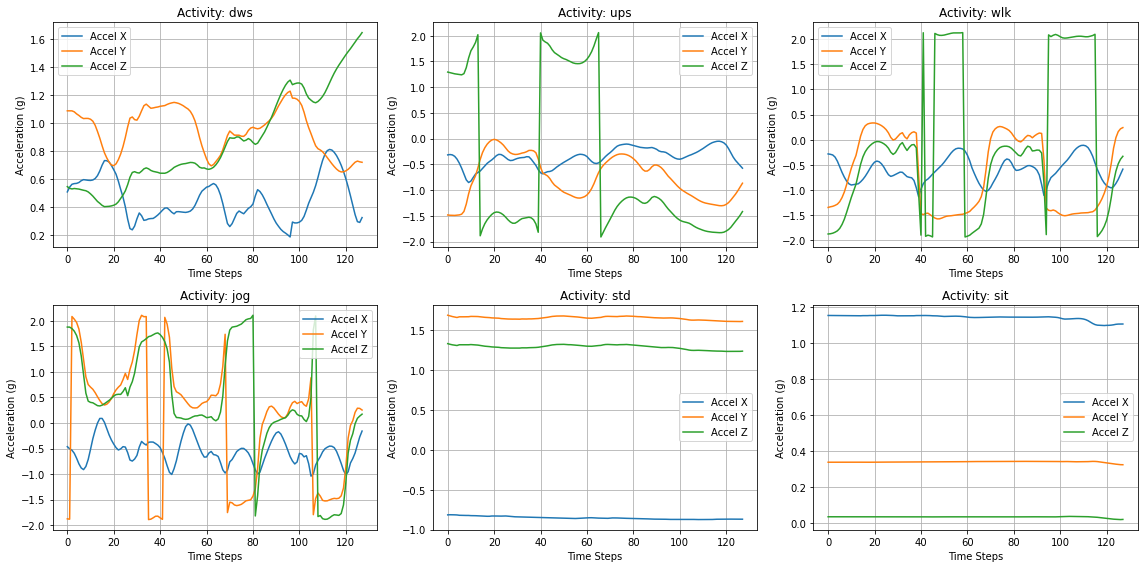

In [6]:
label_names = ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']

# Step 1: Ensure correct format
if len(y.shape) > 1 and y.shape[1] > 1:
    y_labels = np.argmax(y, axis=1)
else:
    y_labels = y.copy()

# Step 2: Plot
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for label, ax in zip(range(6), axes):
    indices = np.where(y_labels == label)[0]
    if len(indices) == 0:
        ax.set_title(f"No data for label {label_names[label]}")
        continue
    idx = indices[0]
    sample = X[idx]
    ax.plot(sample[:, 0], label='Accel X')
    ax.plot(sample[:, 1], label='Accel Y')
    ax.plot(sample[:, 2], label='Accel Z')
    ax.set_title(f"Activity: {label_names[label]}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Acceleration (g)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



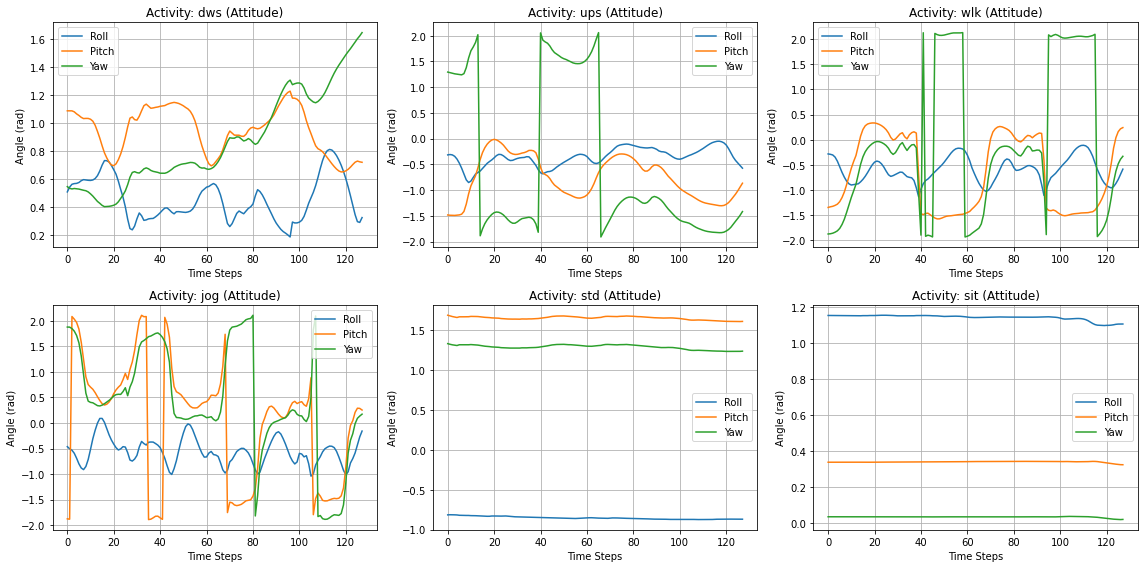

In [7]:
# Ensure y is in label format
if len(y.shape) > 1 and y.shape[1] > 1:
    y_labels = np.argmax(y, axis=1)
else:
    y_labels = y.copy()

# Plot attitude data (roll, pitch, yaw) for each activity
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for label, ax in zip(range(6), axes):
    indices = np.where(y_labels == label)[0]
    if len(indices) == 0:
        ax.set_title(f"No data for label {label_names[label]}")
        continue
    idx = indices[0]
    sample = X[idx]
    ax.plot(sample[:, 0], label='Roll')
    ax.plot(sample[:, 1], label='Pitch')
    ax.plot(sample[:, 2], label='Yaw')
    ax.set_title(f"Activity: {label_names[label]} (Attitude)")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Angle (rad)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### 2.4 Splitting Dataset

In [8]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y_windows)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp.argmax(axis=1))

print(f"[INFO] -- Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


[INFO] -- Train: (15743, 128, 6), Val: (2779, 128, 6), Test: (3269, 128, 6)


## 3. CNN Model Training

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1216      
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 128)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dropout (Dropout)           (None, 3840)              0

## 4. Model Evaluation

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"[INFO] -- Test Accuracy: {accuracy:.4f}")


103/103 [==============================] - 4s 35ms/step - loss: 0.1009 - accuracy: 0.9768
[INFO] -- Test Accuracy: 0.9768


### 4.1 Loss and Accuracy Curves

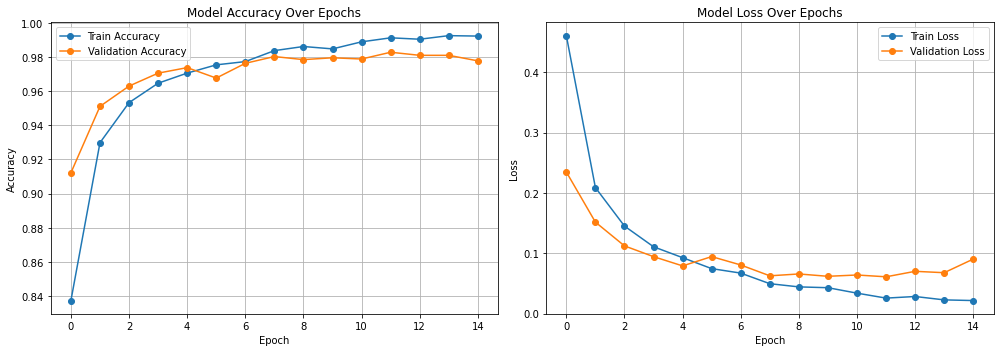

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 4.2 Confusion Matrix

103/103 [==============================] - 5s 35ms/step


<Figure size 576x432 with 0 Axes>

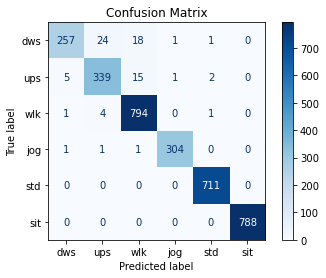

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define activity label names manually (based on your selection)
activity_labels = ["dws", "ups", "wlk", "jog", "std", "sit"]


# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


### 4.3 F1 Scores

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Convert one-hot encoded predictions and labels back to class indices
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'
print(f"[INFO] -- Weighted F1 Score: {f1:.4f}")

# Optional: also print precision and recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"[INFO] -- Precision: {precision:.4f}, Recall: {recall:.4f}")

# Detailed classification report
print("\n[INFO] -- Classification Report:")
print(classification_report(y_true, y_pred, target_names=ACT_LABELS))


103/103 [==============================] - 2s 16ms/step
[INFO] -- Weighted F1 Score: 0.9764
[INFO] -- Precision: 0.9770, Recall: 0.9768

[INFO] -- Classification Report:
              precision    recall  f1-score   support

         dws       0.97      0.85      0.91       301
         ups       0.92      0.94      0.93       362
         wlk       0.96      0.99      0.98       800
         jog       0.99      0.99      0.99       307
         std       0.99      1.00      1.00       711
         sit       1.00      1.00      1.00       788

    accuracy                           0.98      3269
   macro avg       0.97      0.96      0.97      3269
weighted avg       0.98      0.98      0.98      3269



In [21]:
model.save("my_model.keras")


In [17]:
def create_model():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax'))
    return model


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Convert one-hot encoded labels to integer labels
y_int = np.argmax(y, axis=1)

fold_no = 1
f1_scores = []

for train_idx, val_idx in skf.split(X, y_int):
    print(f'\nTraining for fold {fold_no} ...')

    # Split into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]  # Still one-hot for model training

    # Build and compile the model (reuse your existing model-building function)
    model = create_model()  # Replace with your model creation function

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=0,
              validation_data=(X_val, y_val))

    # Evaluate
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_val, axis=1)

    # F1 score for the current fold
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
    f1_scores.append(f1)

    print(f'Fold {fold_no} F1 Score: {f1:.4f}')
    fold_no += 1

# Average F1 Score across all folds
print(f'\nAverage F1 Score across {k} folds: {np.mean(f1_scores):.4f}')



Training for fold 1 ...
137/137 [==============================] - 3s 16ms/step
Fold 1 F1 Score: 0.9728

Training for fold 2 ...
137/137 [==============================] - 3s 19ms/step
Fold 2 F1 Score: 0.9812

Training for fold 3 ...
137/137 [==============================] - 4s 28ms/step
Fold 3 F1 Score: 0.9756

Training for fold 4 ...
137/137 [==============================] - 3s 17ms/step
Fold 4 F1 Score: 0.9823

Training for fold 5 ...
137/137 [==============================] - 3s 20ms/step
Fold 5 F1 Score: 0.9767

Average F1 Score across 5 folds: 0.9777
